# Tutorial: transcriptome annotation with genemunge, archs4 and mygene.info

This notebook demonstrates how to annotate *rnalib* transcriptome features with annotations from public databases using different access APIs.
It consists of three parts:

In **part 1**, we instatiate the human transcriptome with *rnalib* to extract gene lengths and exon counts and use **genemunge** to get a list of housekeeping genes, recount2 expression values and Hellinger distance values. We integrate and plot these data.

In **part 2**, we use *rnalib*'s **archs4** interface to additionally annotate the transcriptome with ARCHS4 expression data (requires the download of a large data file)

In **part 3**, we additionally annotate the transcriptome with **mygene.info** data.

Finnaly, we demonstrate how to store and load these annotations to/from a pickle/dill file.

## Requirements
Before executing this notebook, you need to install all required *rnalib* requirements as well as optional libraries needed by this notebook.
It is recommended to do this in a [Python virtual environment](https://rnalib.readthedocs.io/en/latest/readme.html#installation).

This notebook requires [genemunge](https://github.com/unlearnai/genemunge) a python package for accessing GTex/recount2 data. NOTE that installation of this package requires hdf5 to be installed. See [here](https://stackoverflow.com/questions/73029883/could-not-find-hdf5-installation-for-pytables-on-m1-mac) for installation via homebrew on MacOS.

Note that this notebook as well as *rnalib*'s testing suite use various test resources (genomics data files and indexing structures). There are [different ways](https://rnalib.readthedocs.io/en/latest/readme.html#test-data) 
to get these files. You can either download from GitHub or, if you have `bedtools`, `bgzip` and `tabix` installed, create them automatically by running the `rnalib create_testdata` commandline script or by calling `testdata.create_testdata()` as done below. Refer to `testdata.py` for details how the test data files were created. There are two separate test resource sets:

* *test_resources*: small test datasets that are used by *rnalib*'s test suite
* *large_test_resources*: larger test files that are needed to demonstrate *rnalib* under realistic conditions. 

*Rnalib* knows about the location of the test data via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by 'monkeypatching' (rna.__RNALIB_TESTDATA__ = ...) as shown below. Once this is done, test data resources can be accessed via `rna.get_resource(<resource_id>)`. *Rnalib* will recreate these resources only if they are not found in the configured output folder.

In [1]:
# install additional requirements for this notebook
#%pip install genemunge

import os, pathlib, platform, random
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import genemunge
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,3)

# load rnalib
import rnalib as rna
from rnalib import gi, GI, SEP, display_textarea
display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

# ensure test data
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/" # monkeypatch test data dir
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, (rna.testdata.test_resources,rna.testdata.large_test_resources)) # requires additional tools installed
display(f"Testdata in {rna.__RNALIB_TESTDATA__}")
display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Running rnalib 0.0.3 on python 3.12.1'

Creating testdata:   0%|          | 0/46 [00:00<?, ?it/s]

Creating testdata:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


'Testdata in rnalib_testdata/'

## Part 1: rnalib and genemunge
First, we build subset of human transcriptome containing only canonical, protein coding genes.

In [2]:
t=rna.Transcriptome(
    annotation_gff=rna.get_resource("full_gencode_gff"),
    annotation_flavour='gencode',
    feature_filter=rna.TranscriptFilter().include_tags(['Ensembl_canonical']).include_gene_types(['protein_coding'])
)
t

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/19982 [00:00<?, ?it/s]

Transcriptome with 19982 genes and 74981 tx

### Get housekeeping genes
Using genemunge, we retrieve a list of housekeeping genes, see see https://www.tau.ac.il/~elieis/HKG/

In [5]:
searcher = genemunge.search.Searcher()
housekeeping_genes = searcher.get_housekeeping_genes()
print(f'Identified {len(housekeeping_genes)} housekeeping genes')

Identified 3620 housekeeping genes


### Get tissue-specific expression data
Now, we can compile tissue-specific expression data for housekeeping and all other genes as
well as some gene-related values (average number of exons per tx, gene length).
We exemplary show data for three tissues ('Blood', 'Bone Marrow', 'Brain'), the expression values are tpm normalized.
Using the transcriptomer model, we can easily access gene length and average number of exons (which naturally correlate) for a downstream analysis.

In [6]:
def get_exp_data(t, genes, housekeeping_genes, tissues=('Blood',)):
    # set up an object to describe genes
    describer = genemunge.describe.Describer('symbol')
    # get major versions of gene ids
    ids = [g.feature_id.split('.')[0] for g in genes]
    # create dataframe
    expression_data = pd.DataFrame(index=ids, columns=['hellinger', 'len', 'n_exon', 'HK']+[f"exp_{tissue}" for tissue in tissues])
    expression_data['len'] = [len(g) for g in genes] # get gene lengths
    expression_data['n_exon'] = [np.mean([len(tx.exon) for tx in g.transcript]) for g in genes] # get mean #exons per gene
    # get the expression levels in healthy tissue (in TPM units)
    for tissue in tissues:
        expression_data[f"exp_{tissue}"] = describer.tissue_stats['median'].reindex(ids)[tissue]
    # get the hellinger distance 
    expression_data['hellinger'] = describer.tissue_stats['hellinger'].reindex(ids)
    # is it a HK gene?
    expression_data['HK']=['yes' if g.feature_id.split('.')[0] in housekeeping_genes else 'no' for g in genes]
    return expression_data

# get expression levels of each gene of interest
tissues=('Blood', 'Bone Marrow', 'Brain')
exp = get_exp_data(t, t.genes, housekeeping_genes, tissues)
exp.describe(include='all')

,hellinger,len,n_exon,HK,exp_Blood,exp_Bone Marrow,exp_Brain
count,19640.000000,1.998200e+04,19982.000000,19982,19640.000000,19640.000000,19640.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,no,NaN,NaN,NaN
freq,NaN,NaN,NaN,16374,NaN,NaN,NaN
mean,0.970893,6.877190e+04,6.351230,NaN,34.773819,33.032600,34.321095
std,0.049021,1.329786e+05,5.142015,NaN,1824.817139,386.487213,963.890137
min,0.339648,3.900000e+01,1.000000,NaN,0.000000,0.000000,0.000000
25%,0.963851,9.741000e+03,3.500000,NaN,0.067002,0.089170,0.490639
50%,0.987020,2.743100e+04,5.250000,NaN,1.147619,3.912210,3.808928
75%,0.998689,7.164075e+04,7.750000,NaN,6.222931,19.721184,11.014380


### Plot the data
Now, we plot the tissue-specific expression and the Hellinger distance for housekeeping genes 
vs all others. 

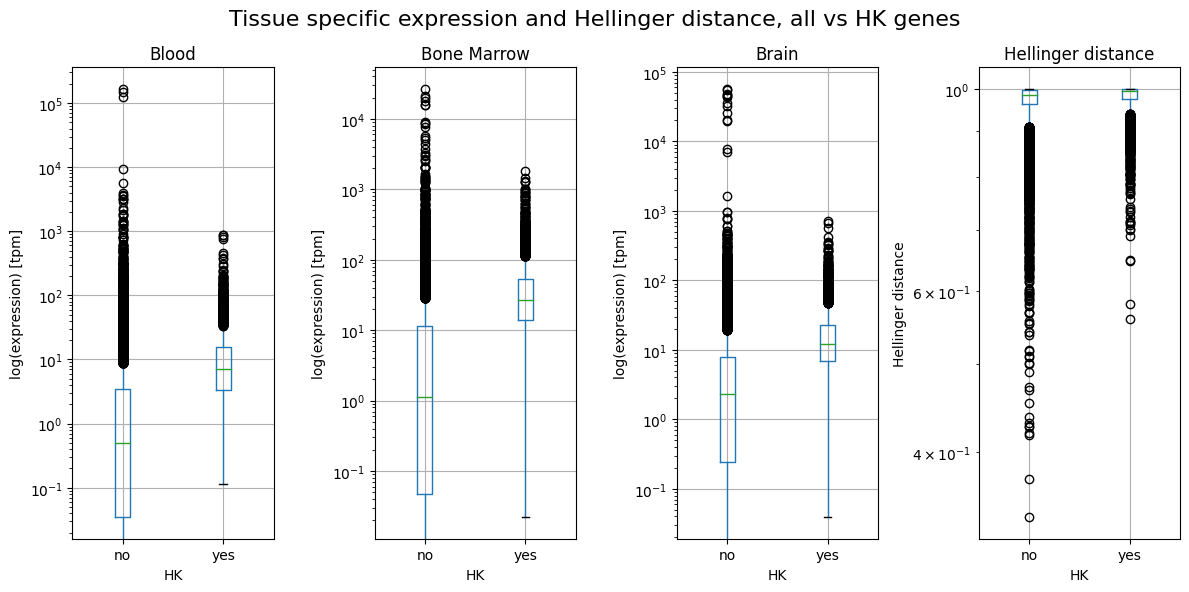

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i, tissue in enumerate(tissues):
    exp.boxplot(column=f"exp_{tissue}", by='HK', ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_ylabel('log(expression) [tpm]')
    ax[i].set_title(tissue)
exp.boxplot(column='hellinger', by='HK', ax=ax[-1])
ax[-1].set_yscale('log')
ax[-1].set_title('Hellinger distance')
ax[-1].set_ylabel('Hellinger distance')
fig.tight_layout()
_ = fig.suptitle(t='Tissue specific expression and Hellinger distance, all vs HK genes', fontsize=16)

As expected, housekeeping genes have higher expression levels. They also show higher
Hellinger distance values which range between 0 (all tissues have the same expression) and 1 (at least one tissue pair are easily distinguished).

Now, we plot the Hellinger distance vs number of exons and vs gene length. 

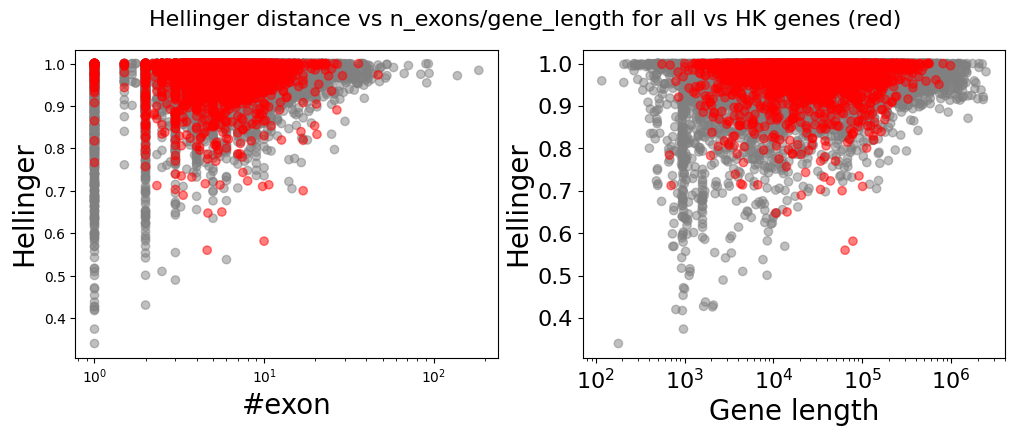

In [8]:
# plot hellinger distance vs gene length
exp=exp.sort_values('HK')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.scatter(exp['n_exon'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax1.set_xlabel('#exon', fontsize=20)
ax1.set_xscale('log')
ax1.set_ylabel('Hellinger', fontsize=20)

ax2.scatter(exp['len'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax2.set_xlabel('Gene length', fontsize=20)
ax2.set_xscale('log')
ax2.set_ylabel('Hellinger', fontsize=20)

fig.suptitle(t='Hellinger distance vs n_exons/gene_length for all vs HK genes (red)', fontsize=16);
plt.show()

Longer genes have higher Hellinger distance.

## Part 2: rnalib and archs4

[ARCHS4](https://maayanlab.cloud/archs4/) is a large public data resource that provides access to gene and transcript counts uniformly processed from all human and mouse RNA-seq experiments from the Gene Expression Omnibus (GEO) and the Sequence Read Archive (SRA). The data can be downloaded as large h5 data files that can then be accessed via an *rnaliib* utility method.

Note that this part uses some resources that were defined in part 1 of this tutorial, so be sure to run part 1 first.

### Download archs4 data
First, we need to download an h5 file from archs4 that contains gene level expression counts.
Note that this resource is not defined in *rnalib* test datasets and this cell demonstrates how you can add own (test) resources.

In [9]:
archs4_test_resources = {'human_gene_v2.2': {
    'uri': 'https://s3.dev.maayanlab.cloud/archs4/files/human_gene_v2.2.h5',
    'filename': 'bigfiles/human_gene_v2.2.h5',
    'recreate': False}}
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, archs4_test_resources)
# access file with rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)

Creating testdata:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


### Create archs4 dataset
Now we can use *rnalib*'s archs4 interface and create an Archs4Dataset from these data that can then be quired.
The example below shows how to query for all contained HiSeq datasets with a minimum number of sequenced reads.

In [10]:
# query the dataset for samples
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    # a4.describe() # show some sampled data
    # query recent HiSeq datasets with sufficient reads
    df = a4.get_sample_metadata(filter_string = "readsaligned>5000000 & instrument_model.str.contains('HiSeq')") 

  0%|          | 0/468 [00:00<?, ?it/s]

INFO:root:Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


As the data is in a local dataframe now and we can further query it with pandas:

In [11]:
# now, we have a local dataframe and can get familiar with the data
display("Here are the used instruments:", set(df.instrument_model))
display(SEP, "Here are the GEO series with most associated samples:")
df.groupby('series_id').size().reset_index(name='counts').\
    sort_values('counts', ascending=False).head()

'Here are the used instruments:'

{'HiSeq X Ten',
 'Illumina HiSeq 1000',
 'Illumina HiSeq 1500',
 'Illumina HiSeq 2000',
 'Illumina HiSeq 2500',
 'Illumina HiSeq 3000',
 'Illumina HiSeq 4000'}

---

'Here are the GEO series with most associated samples:'

,series_id,counts
7769,GSE193677,2484
281,GSE103147,1594
7170,GSE183635,1502
9014,"GSE47774,GSE47792",1366
6740,GSE177040,1332


### Access expression data
You can access expression counts for a given number of samples via the `get_counts()` method.

In [12]:
# lets get the counts for a random sample of our dataframe
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    df_cnt = a4.get_counts(samples = df.sample(5).index) 
df_cnt

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSG00000290126,ENSG00000290127,ENSG00000290146,ENSG00000290147,ENSG00000290149,ENSG00000290162,ENSG00000290163,ENSG00000290164,ENSG00000290165,ENSG00000290166
GSM2699683,584,90,414,202,106,0,93,773,301,374,...,32,1,73,0,0,0,1,1,0,0
GSM4505215,116,0,429,2154,23,0,10,97,66,44,...,3,1,32,0,0,0,0,0,1,0
GSM4742650,1350,1,865,456,308,91,626,574,805,1162,...,13,6,287,3,0,0,0,0,0,1
GSM4891045,341,0,526,97,81,0,204,1787,124,634,...,0,0,43,0,0,0,0,0,0,0
GSM4891077,820,0,636,318,277,1,5772,557,250,458,...,2,0,97,0,2,1,0,0,0,0


### Annotate housekeeping genes with expression counts
Here, we show how to annotate a set of genes (all housekeeping examples from genemunge in this example) with archs4 expression values.

In [13]:
# First, create a list of housekeeping genes. We re-use the genemunge housekeeping list from above which contains ensembl gene ids (w/o minor version num,ber).
# Here, we add a boolean 'housekeeping_gene' annotation to all genes in the transcriptome and create list (hkg) of housekeeping genes.
for g in t.genes:
    maj = g.feature_id.split('.')[0] # get major versions of gene ids
    t[g]['housekeeping_gene'] = maj in housekeeping_genes
hkg = [g for g in t.genes if g.housekeeping_gene]

In [14]:
# Now we get counts for 1k random samples but for housekeeping genes only. 
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    df_cnt = a4.get_counts(samples=df.sample(1000).index, gene_symbols=[g.gene_name for g in hkg]) 
df_cnt

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


,DPM1,SCYL3,GCLC,BAD,LAP3,M6PR,ALS2,RBM5,ARF5,POLDIP2,...,PPFIA1,PEX5,CC2D1A,MCTS1,LDHA,GPS2,CTTN,UBL7,CYFIP1,PRKACA
GSM1076108,709,307,602,283,1800,1586,978,6785,2168,1168,...,2,354,198,255,1332,959,2956,88,0,34
GSM1098187,956,211,767,660,1068,3384,623,2051,1767,2985,...,398,186,347,534,13859,525,2789,463,552,1018
GSM1156877,97,61,218,236,186,371,818,791,669,480,...,0,61,193,110,575,115,405,129,0,345
GSM1157638,124,77,242,158,233,355,967,733,553,400,...,0,74,117,116,592,110,371,124,4,163
GSM1157830,185,77,308,222,318,603,858,885,716,597,...,0,92,196,133,1925,147,538,179,32,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6971372,427,567,3398,360,1383,1019,872,1947,591,627,...,162,136,391,220,613,203,1737,66,196,96
GSM7011542,3828,357,1048,1706,3166,10287,2313,2161,4035,3971,...,212,446,784,1039,28400,1518,1823,629,1168,1528
GSM7115698,1189,277,540,2190,978,1836,651,5162,9080,2633,...,0,711,646,847,2558,446,1992,758,0,354
GSM7115718,769,446,749,932,971,2282,1876,7400,3542,2512,...,290,569,737,1051,2885,553,2902,610,254,1639


Now, we annotate all hkg genes with these archs4 counts. We add two annotations, the list of counts per sample (archs4_cnt) and a mean value of those (archs4_mean) 

In [15]:
for g in hkg:
    t.anno[g]['archs4_cnt'] = df_cnt[g.gene_name] if g.gene_name in df_cnt.columns else None
    t.anno[g]['archs4_mean'] = np.mean(df_cnt[g.gene_name]) if g.gene_name in df_cnt.columns else None

Here we show the data fro one example gene:

In [16]:
display(t.anno[t['DPM1']]) # show all annotations of gene
display(t['DPM1'].archs4_cnt[df_cnt.index[0]]) # access individual sample
# convert to a pandas dataframe and show HK genes only
df = t.iterator(feature_types='gene').to_dataframe(excluded_columns=('feature_type','gff_feature_type', 'gene_type'))
df[df['housekeeping_gene']].head()

{'housekeeping_gene': True,
 'archs4_cnt': GSM1076108     709
 GSM1098187     956
 GSM1156877      97
 GSM1157638     124
 GSM1157830     185
               ... 
 GSM6971372     427
 GSM7011542    3828
 GSM7115698    1189
 GSM7115718     769
 GSM854409      372
 Name: DPM1, Length: 1000, dtype: uint32,
 'archs4_mean': 1254.221}

709

,Chromosome,Start,End,Strand,feature_id,archs4_mean,housekeeping_gene,archs4_cnt,gene_name,source
4,chr1,944203,959309,-,ENSG00000188976.11,2650.053,True,GSM1076108 1395 GSM1098187 4151 GSM11568...,NOC2L,HAVANA
16,chr1,1216909,1232067,-,ENSG00000078808.19,3022.524,True,GSM1076108 1940 GSM1098187 3303 GSM11568...,SDF4,HAVANA
17,chr1,1232237,1235041,+,ENSG00000176022.7,604.109,True,GSM1076108 395 GSM1098187 470 GSM11568...,B3GALT6,HAVANA
19,chr1,1253909,1273864,-,ENSG00000160087.21,1116.825,True,GSM1076108 912 GSM1098187 998 GSM11568...,UBE2J2,HAVANA
21,chr1,1292390,1309609,-,ENSG00000131584.19,1368.694,True,GSM1076108 1665 GSM1098187 942 GSM115...,ACAP3,HAVANA


### Plot the data
Finally, we filter for housekeeping genes with high mean expression over the annotated samples and plot their expression values as boxplots.

/var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/ipykernel_8444/83583917.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


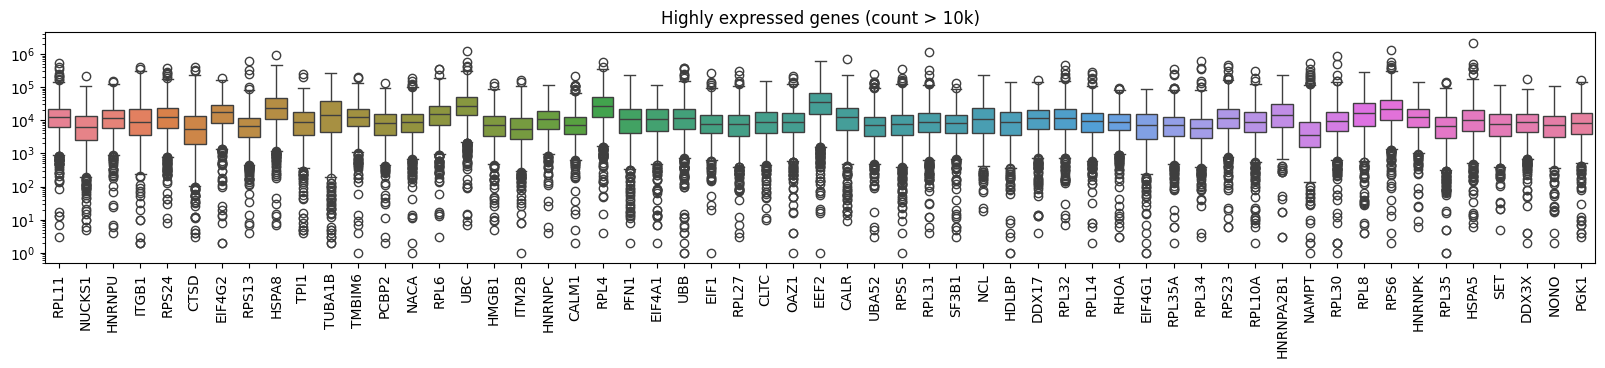

In [17]:
# create a gene: [exp_val1, ..., exp_valn] dict of HK genes with mean exp > 10k
high_mean_hkg = {g.gene_name: list(g.archs4_cnt) for g in hkg if g.get('archs4_mean',None) is not None and g.get('archs4_mean',None) >10000}
# plot
ax = sns.boxplot(data=high_mean_hkg, log_scale=True)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
_ = ax.set_title('Highly expressed genes (count > 10k)')

## Part 3: Pathway analysis with rnalib and mygene.info

*Rnalib* integrates with [MyGene.info](https://docs.mygene.info/) via its [python API](https://docs.mygene.info/projects/mygene-py/en/latest/).
In this part, we demonstrate how to annotate an _rnalib_ transcriptome with mygene.info data.

### Annotate with mygene.info data

_Rnalib_ supports automatic annotation with mygene.info data via the `annotate_with_mygene()` method. This method submits batches 
gene ids to mygene and stores the returned annotation data in the transcriptome `anno` dict.
Here, we annotate all genes with KEGG pathway data (takes ~1min). If annotation field names are not configured then _rnalib_ will use the passed mygene.info field names with dots replaced by underscores (e.g., 'pathway.kegg' -> 'pathway_kegg').

In [18]:
t.annotate_with_mygene('pathway.kegg', disable_progressbar=False)
# now we can access the data...
display(f"Here are the first 10 Kegg pathways of ACTB")
for pw in t['ACTB'].pathway_kegg[:10]:
    display(pw)
display("...")
print(Counter([type(g.pathway_kegg) for g in t.genes]))

  0%|          | 0/20 [00:00<?, ?it/s]

'Here are the first 10 Kegg pathways of ACTB'

{'id': 'hsa04015', 'name': 'Rap1 signaling pathway - Homo sapiens (human)'}

{'id': 'hsa04145', 'name': 'Phagosome - Homo sapiens (human)'}

{'id': 'hsa04210', 'name': 'Apoptosis - Homo sapiens (human)'}

{'id': 'hsa04390', 'name': 'Hippo signaling pathway - Homo sapiens (human)'}

{'id': 'hsa04510', 'name': 'Focal adhesion - Homo sapiens (human)'}

{'id': 'hsa04520', 'name': 'Adherens junction - Homo sapiens (human)'}

{'id': 'hsa04530', 'name': 'Tight junction - Homo sapiens (human)'}

{'id': 'hsa04611', 'name': 'Platelet activation - Homo sapiens (human)'}

{'id': 'hsa04613',
 'name': 'Neutrophil extracellular trap formation - Homo sapiens (human)'}

{'id': 'hsa04670',
 'name': 'Leukocyte transendothelial migration - Homo sapiens (human)'}

'...'

Counter({<class 'NoneType'>: 12162, <class 'list'>: 7820})


We can also annotate multiple annotation fields in parallel (see [here](https://docs.mygene.info/en/latest/doc/data.html#available-fields)) and use own annotation field names. Here we add some ClinGen data fields:

In [19]:
n_annotated = t.annotate_with_mygene({"clingen.clinical_validity.classification": "classification", 
                                      "clingen.clinical_validity.moi": "moi", 
                                      "clingen.clinical_validity.disease_label": "disease"}, 
                                      disable_progressbar=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Let's show some annotation data for 10 random genes. The added annotations can be accessed via "dot" notation which ensures code readability.
Note that "classification" and 'moi' are of type "keyword" in mygene (see rna.mygeneinfo_fields) and can have multiple values. _Rnalib_ ensures that a list is returned for such fields by applying mygene's `alwayslist` method.

In [20]:
for g in random.sample([g for g in t.genes if g.classification], 10):
    display(f"{g.gene_name}: {g.disease} ({g.classification}), inheritance: {g.moi}")

"SCN11A: obsolete autosomal dominant hereditary sensory and autonomic neuropathy (['definitive']), inheritance: ['AD']"

"DLL1: neurodevelopmental disorder with nonspecific brain abnormalities and with or without seizures (['definitive']), inheritance: ['AD']"

"KMT2D: Kabuki syndrome 1 (['definitive']), inheritance: ['AD']"

"HAL: histidinemia (['limited']), inheritance: ['AR']"

"PURA: complex neurodevelopmental disorder (['definitive']), inheritance: ['AD']"

"UPK3A: congenital anomaly of kidney and urinary tract (['disputed']), inheritance: ['AD']"

"HNRNPR: syndromic intellectual disability (['definitive']), inheritance: ['AD']"

"PSAT1: neurometabolic disorder due to serine deficiency (['definitive']), inheritance: ['AR']"

"COQ8B: mitochondrial disease (['definitive']), inheritance: ['AR']"

"XPNPEP3: nephronophthisis-like nephropathy 1 (['definitive']), inheritance: ['AR']"

### Filtering and conversion to a dataframe
We can easily filter genes by list comprehension and convert the results to a pandas dataframe:

In [21]:
ciliopathy_genes = [g for g in t.genes if g.disease=='ciliopathy'] # create a list of ciliopathy genes via list comprehension
display(f"{len(ciliopathy_genes)} genes associated with ciliopathy according to ClinGen")

# iterate over selected features + transcriptome annotations and convert to a pandas dataframe. Exclude some output columns and sort by classification column.
rna.it(t, features=set(ciliopathy_genes)). \
    to_dataframe(excluded_columns=['gene_type', 'source', 'transcript_type', 'gff_feature_type']). \
    sort_values('classification')

'26 genes associated with ciliopathy according to ClinGen'

,Chromosome,Start,End,Strand,feature_id,feature_type,moi,housekeeping_gene,pathway_kegg,disease,archs4_mean,classification,archs4_cnt,gene_name
0,chr10,95659823,95694143,-,ENSG00000119977.22,gene,[AR],True,None,ciliopathy,1138.436,[definitive],GSM1076108 512 GSM1098187 982 GSM11568...,TCTN3
22,chr4,122732702,122744942,+,ENSG00000181004.10,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,BBS12
21,chr16,53598153,53703938,-,ENSG00000103494.16,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,RPGRIP1L
20,chr11,66510606,66533613,+,ENSG00000174483.20,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,BBS1
19,chr16,75536741,75556289,-,ENSG00000205084.12,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,TMEM231
18,chr16,56465640,56582667,-,ENSG00000125124.14,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,BBS2
17,chr12,76344474,76348415,-,ENSG00000179941.9,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,BBS10
14,chr16,27550133,27780344,+,ENSG00000047578.14,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,KATNIP
13,chr15,72686179,72738475,+,ENSG00000140463.14,gene,[AR],True,None,ciliopathy,532.404,[definitive],GSM1076108 279 GSM1098187 610 GSM1156877...,BBS4
24,chr8,93754844,93819234,+,ENSG00000164953.17,gene,[AR],False,None,ciliopathy,NaN,[definitive],None,TMEM67


### Plot the data

Now, we can combine KEGG pathway and ClinGen data. 
Here, we define a method that estimates the most common assigned KEGG pathway for each disease and calculates the fraction of disease-associated genes that are annotated with this pathway. We then plot these data considering all genes:

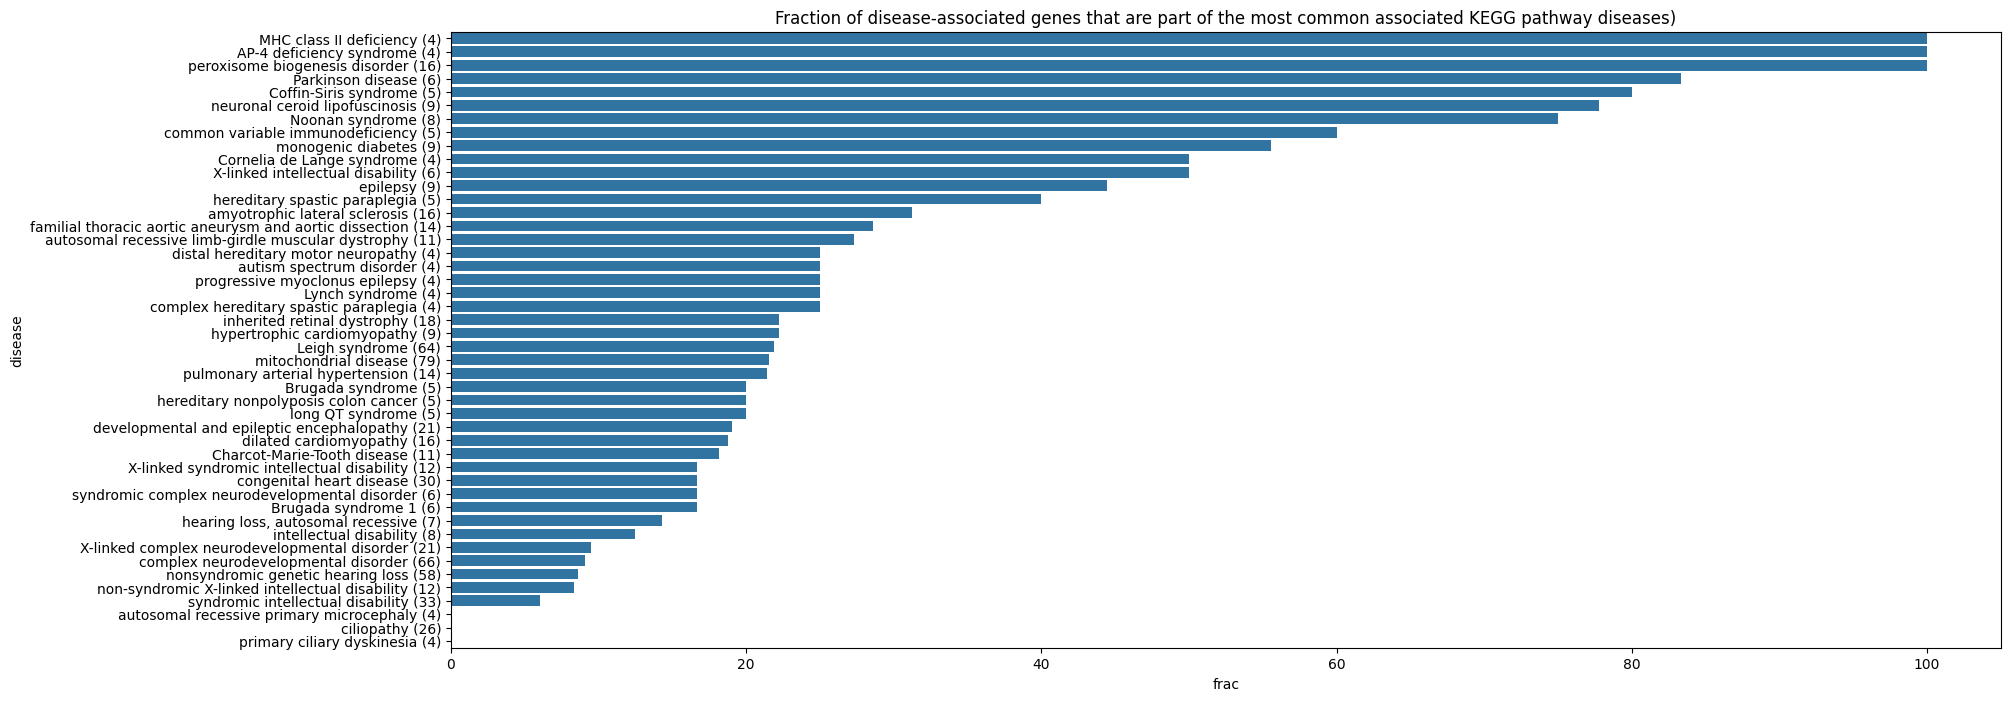

In [22]:
def get_disease_ngenes_list(genes):
    dat=list()
    diseases = Counter([g.disease for g in genes if g.disease]) # count genes per disease
    diseases_3 = [d for d,c in diseases.items() if c>3] # consider only diseases with more than 3 genes
    for disease in diseases_3: 
        d_genes = [g for g in t.genes if g.disease==disease] # get the genes via list comprehension
        d_pw = Counter() # counter of pathwayids:n_genes
        for g in d_genes: 
            if g.pathway_kegg is not None:
                for pw in g.pathway_kegg: # a gene can be associated with 0..n pathways
                    if pw is not None:
                        d_pw[pw["id"]]+=1 # count per pathway id
        pw_id, pw_cnt = d_pw.most_common()[0] if len(d_pw)>0 else ("None", 0) # get number of genes that are associated with the most common pathway for this disease
        perc_pw = pw_cnt / len(d_genes) * 100 # calc percentage of all disease-associated genes
        dat.append([f"{disease} ({len(d_genes)})", perc_pw]) # add to data list
    return pd.DataFrame(dat, columns=['disease', 'frac']).sort_values('frac', ascending=False)

# plot with seaborn
plt.rcParams["figure.figsize"] = (20,8)
_ = sns.barplot(y='disease', x='frac', data=get_disease_ngenes_list(t.genes))
_= plt.title(f"Fraction of disease-associated genes that are part of the most common associated KEGG pathway diseases)")

As you can see, there are some diseases where all genes are associated with a common pathway and others where none is (e.g., ciliopathy as you can check in 
the datatable above). Most diseases, however, are associated with <= 3 genes and we don#t plot the data for those.

# Part 4 : ClinVar access
In this section, we will access...

TOD: add API to rnalib.
* available fields: https://docs.myvariant.info/en/latest/doc/data.html#available-fields
* 


In [11]:
import biothings_client
vc = biothings_client.get_client('variant')

In [82]:
# collect all clinvar variants from the given genes
clinvar_vars = {}
goi = ['EXOSC1','EXOSC2','EXOSC3','EXOSC4','EXOSC5','EXOSC6','EXOSC7','EXOSC8','EXOSC9','EXOSC10',
      'DIS3','DIS3L','DIS3L2','TUT4', 'TUT7']
for gn in goi:
    loc = str(t[gn].get_stranded(None))
    clinvar_vars[gn]=dict()
    for v in vc.query(gn + ' AND _exists_:clinvar', 
                      fields=['_id','clinvar'], 
                      assembly='hg38', fetch_all=True):
        if 'clinvar' in v:
            clinvar_vars[gn][v['_id']] = v

INFO:biothings.client:Fetching 8 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 233 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 151 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 11 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 72 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 145 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 14 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 82 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 221 variant(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 34 variant(s) . . .
ERROR:biothings.client:No more result

<Axes: >

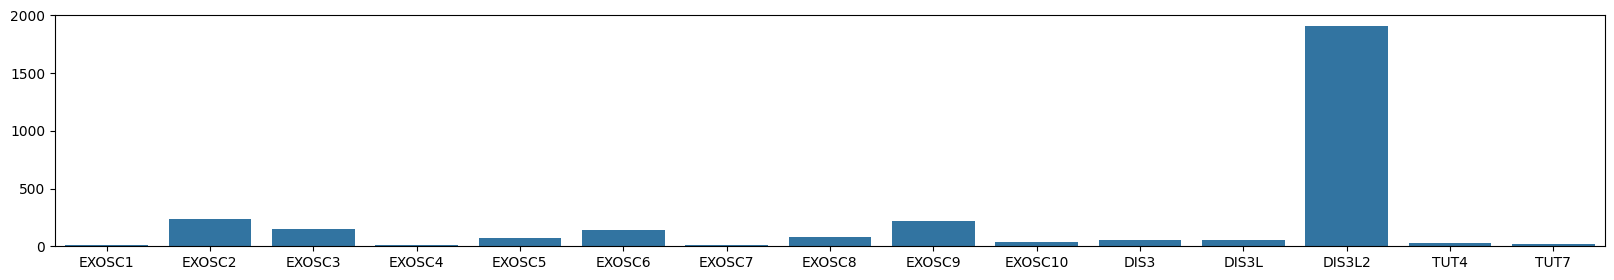

In [83]:
sns.barplot({k:len(v) for k,v in clinvar_vars.items()})

In [116]:
tab=list()
for gn in clinvar_vars:
    for v in clinvar_vars[gn]:
        rcvs=rna.to_list(clinvar_vars[gn][v]['clinvar']['rcv'])
        vtype=clinvar_vars[gn][v]['clinvar']['type']
        for rcv in rcvs:
            cond=[c['name'] for c in rna.to_list(rcv['conditions'])]
            cond='; '.join(cond)     
            status = rcv['review_status']
            tab.append( (gn, v, rcv['accession'], rcv['clinical_significance'], 
                         rcv['preferred_name'], vtype, #status,
                         cond ) )
tab = pd.DataFrame.from_records(tab, columns=['gene_name', 'HGVS', 'accession', 'clinical_significance', 'preferred_name', 'vtype', 'conditions'])
tab

,gene_name,HGVS,accession,clinical_significance,preferred_name,vtype,conditions
0,EXOSC1,chr10:g.97441201G>A,RCV002674550,Uncertain significance,NM_016046.5(EXOSC1):c.281C>T (p.Pro94Leu),single nucleotide variant,Inborn genetic diseases
1,EXOSC1,chr10:g.97437734C>T,RCV002727717,Uncertain significance,NM_016046.5(EXOSC1):c.362G>A (p.Ser121Asn),single nucleotide variant,Inborn genetic diseases
2,EXOSC1,chr10:g.97437740T>C,RCV003277995,Uncertain significance,NM_016046.5(EXOSC1):c.356A>G (p.Tyr119Cys),single nucleotide variant,Inborn genetic diseases
3,EXOSC1,chr10:g.97445970T>C,RCV002986846,Uncertain significance,NM_016046.5(EXOSC1):c.16A>G (p.Arg6Gly),single nucleotide variant,Inborn genetic diseases
4,EXOSC1,chr10:g.97445775G>A,RCV001380415,Pathogenic,NM_016046.5(EXOSC1):c.104C>T (p.Ser35Leu),single nucleotide variant,"Pontocerebellar hypoplasia, type 1F"
...,...,...,...,...,...,...,...
3320,TUT7,chr9:g.86323199C>T,RCV000901250,Benign,NM_024617.4(TUT7):c.2551G>A (p.Asp851Asn),single nucleotide variant,not provided
3321,TUT7,chr9:g.86346438G>A,RCV000965109,Benign,NM_024617.4(TUT7):c.563C>T (p.Thr188Ile),single nucleotide variant,not provided
3322,TUT7,chr9:g.86323157T>C,RCV003363211,Uncertain significance,NM_024617.4(TUT7):c.2593A>G (p.Asn865Asp),single nucleotide variant,Inborn genetic diseases
3323,TUT7,chr9:g.86323028C>T,RCV003305605,Uncertain significance,NM_024617.4(TUT7):c.2722G>A (p.Val908Met),single nucleotide variant,Inborn genetic diseases


In [110]:
Counter(tab['clinical_significance'])

Counter({'Uncertain significance': 1887,
         'Likely benign': 1026,
         'Benign': 200,
         'Pathogenic': 76,
         'Likely pathogenic': 54,
         'Conflicting interpretations of pathogenicity': 50,
         'Benign/Likely benign': 18,
         'Pathogenic/Likely pathogenic': 14})

Text(0.5, 1.0, 'Pathogenic ClinVar variants')

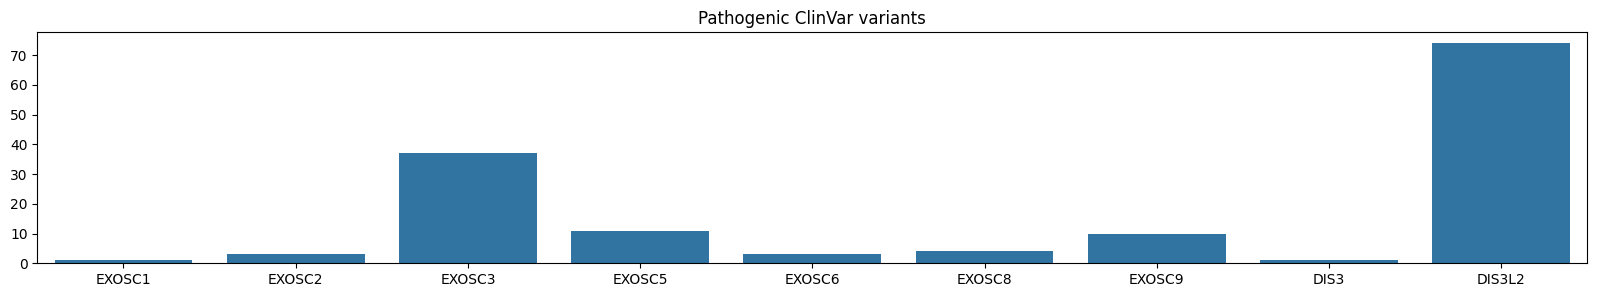

In [115]:
df = tab[tab['clinical_significance'].isin(['Pathogenic','Likely pathogenic','Pathogenic/Likely pathogenic'])]
ax = sns.barplot(Counter(df['gene_name']))
ax.set_title('Pathogenic ClinVar variants')

In [117]:
tab.to_csv('rnalib_testdata/div/exosc_clinvar_variants.tsv', sep='\t', index=False)

In [81]:
t['EXOSC3']

gene@chr9:37759234-37832117

# Storing annotations to disk

Note that you can save/load transcriptome annotations to/from disk using the `save_annotations(...)` and `load_annotations(...)` methods. This methods uses
_dill_ for proper serialization of arbitrary annotation values and will store only non-empty annotations. 

In [23]:
import tempfile, dill
with tempfile.TemporaryDirectory() as tmp:
    pkfile = os.path.join(tmp, 'transcriptome_anno.pk')
    t.save_annotations(pkfile)
    display('\n'.join(rna.dir_tree(pathlib.Path(tmp))))
    with open(pkfile, 'rb') as infile:
        loaded = dill.load(infile)
        for k, val in list(loaded.items())[:10]: # print 10 items
            print(k, val)
    # instantiate another transcriptome with the same config
    del t
    t=rna.Transcriptome(
        annotation_gff=rna.get_resource("full_gencode_gff"),
        annotation_flavour='gencode',
        feature_filter=rna.TranscriptFilter().include_tags(['Ensembl_canonical']).include_gene_types(['protein_coding'])
    )
    print("Loading annotations")
    t.load_annotations(pkfile)

INFO:root:Storing annotations keys: {'moi', 'housekeeping_gene', 'disease', 'archs4_cnt', 'archs4_mean', 'pathway_kegg', 'dna_seq', 'classification'} to /var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/tmpbq4pdcvz/transcriptome_anno.pk


'└── transcriptome_anno.pk (35.61 MB)'

('ENSG00000186092.7', 'gene', 'chr1', 65419, 71585, '+') {'moi': None, 'housekeeping_gene': False, 'disease': None, 'pathway_kegg': [{'id': 'hsa04740', 'name': 'Olfactory transduction - Homo sapiens (human)'}], 'classification': None}
('ENSG00000284733.2', 'gene', 'chr1', 450740, 451678, '-') {'moi': None, 'housekeeping_gene': False, 'disease': None, 'pathway_kegg': [{'id': 'hsa04740', 'name': 'Olfactory transduction - Homo sapiens (human)'}], 'classification': None}
('ENSG00000284662.2', 'gene', 'chr1', 685716, 686654, '-') {'moi': None, 'housekeeping_gene': False, 'disease': None, 'pathway_kegg': [{'id': 'hsa04740', 'name': 'Olfactory transduction - Homo sapiens (human)'}], 'classification': None}
('ENSG00000187634.13', 'gene', 'chr1', 923923, 944575, '+') {'moi': None, 'housekeeping_gene': False, 'disease': None, 'pathway_kegg': None, 'classification': None}
('ENSG00000188976.11', 'gene', 'chr1', 944203, 959309, '-') {'housekeeping_gene': True, 'moi': None, 'disease': None, 'archs4_

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/19982 [00:00<?, ?it/s]

INFO:root:Loaded 19982 annotations from /var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/tmpbq4pdcvz/transcriptome_anno.pk


Loading annotations


Here, we repeat the KEGG pathway plot from above, but now consider only the previously annotated housekeeping genes to assert that we can 
access the annotations we just loaded from disk.

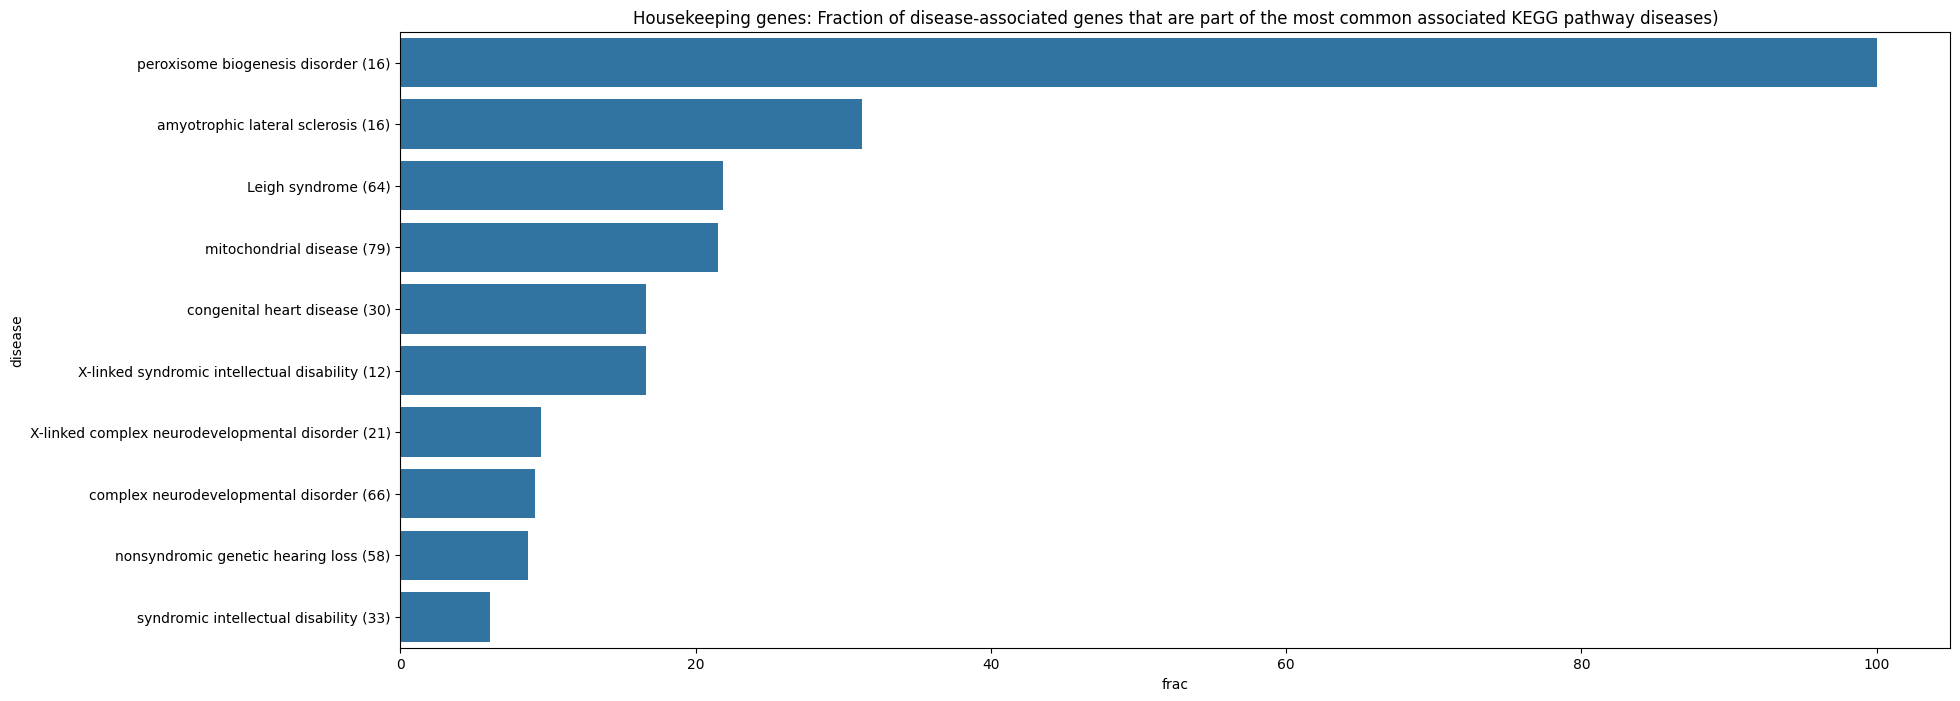

In [24]:
# plot with seaborn
plt.rcParams["figure.figsize"] = (20,8)
_ = sns.barplot(y='disease', x='frac', data=get_disease_ngenes_list([g for g in t.genes if g.housekeeping_gene]))
_= plt.title(f"Housekeeping genes: Fraction of disease-associated genes that are part of the most common associated KEGG pathway diseases)")

# Summary

This concludes our annotation tutorial. This tutorial demonstrated:
* How to annotate *rnalib* transcriptomes with genemunge data
* How to annotate *rnalib* transcriptomes with archs4 data
* How to annotate *rnalib* transcriptomes with mygene.info data
* How to filter, convert and access these data
* How to load/store these annotations to/from disk
